# WGAN-GP (Wasserstein Generative Adversarial Networks with Gradient Penalty)

In [ ]:
import torch
from torch import nn

from tqdm.auto import tqdm

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

torch.manual_seed(0)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2  # normalise
    image_unflat = image_tensor.detach().cpu()  # shift the tensor to cpu
    image_grid = make_grid(image_unflat[:num_images], nrow=5)  # make grid
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  # imshow takes in H, W, C rather than C, H, W
    plt.show()

In [ ]:
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes,
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

### Generator

In [ ]:
# For initialising generator, we need to know input channels(dim of z),
# output channels(channels in image), and hidden channels parameters
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector,
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Discriminator

In [ ]:
# For initialising discriminator, we need to know
# input channels(channels in img), and the hidden
# channels.
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)


### Training Initializations

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10  # weight of the gradient penalty
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 251763441.75it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41202616.95it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 166235401.21it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19439315.07it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


### Gradient Penalty

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1) ** 2) # taking the mean as gradient_norm is calculated for all gradients in the batch

    return penalty

### Losses

In [ ]:
def get_gen_loss(critic_fake_pred):
  gen_loss = -torch.mean(critic_fake_pred)
  return gen_loss


In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    # Calculate the loss as the difference between the mean of critic's scores for real and fake images
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred)

    # Calculate the weighted gradient penalty
    weighted_gp = c_lambda * gp

    # Add the weighted gradient penalty to the critic's loss
    crit_loss += weighted_gp

    return crit_loss

### Putting It All Together

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: -3.1627091350890697, critic loss: -123.3946461901308


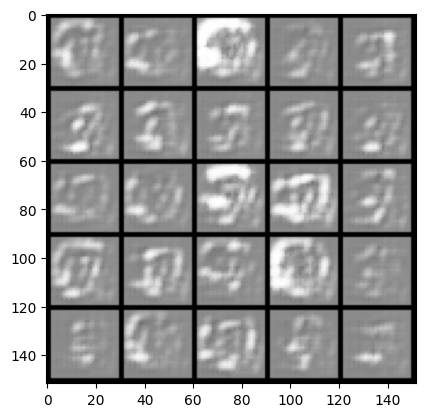

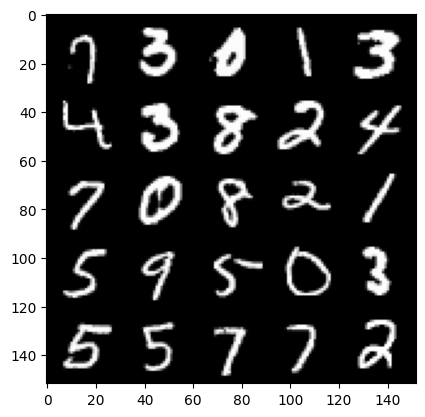

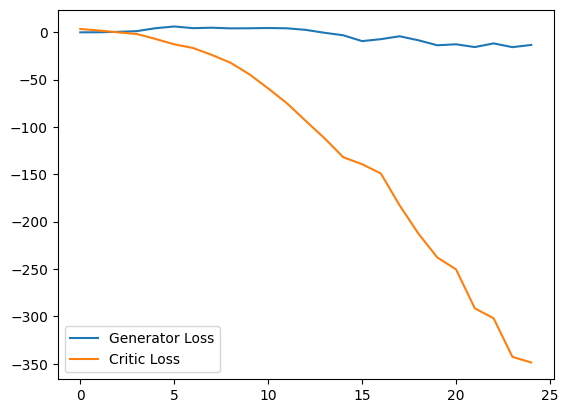

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: -31.296082950532437, critic loss: -591.0483347076417


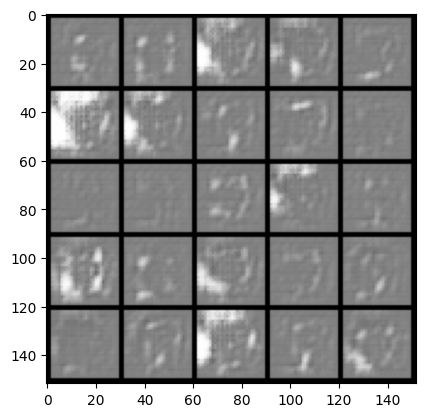

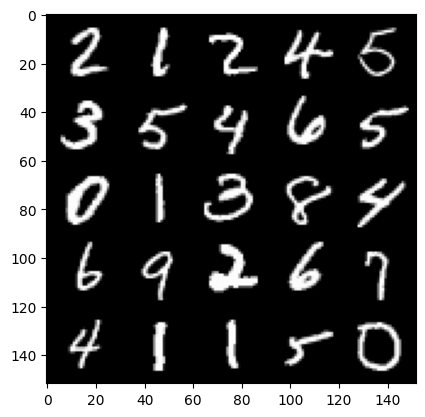

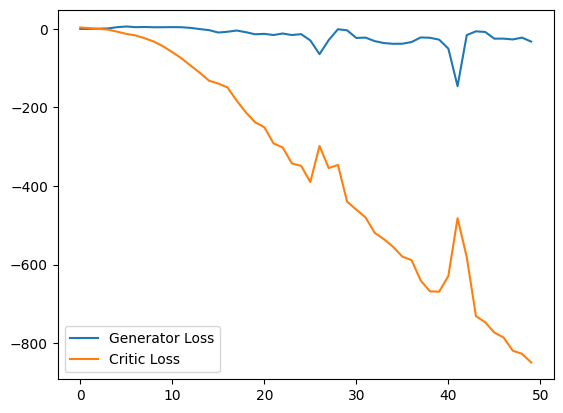

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: -17.903606638908386, critic loss: -931.1625551025396


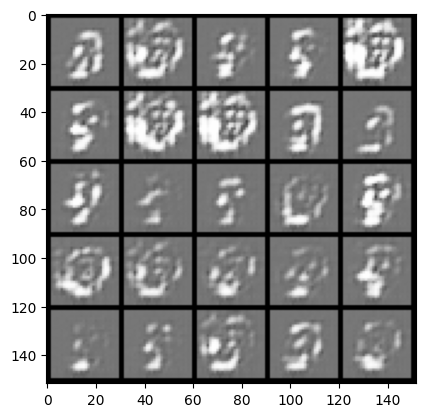

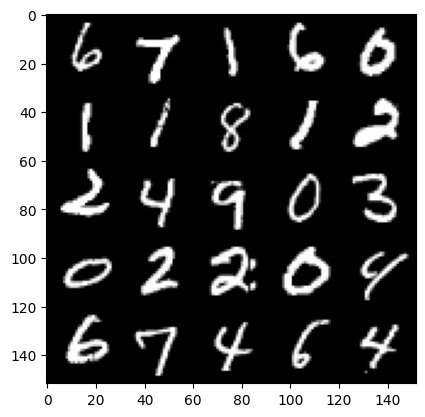

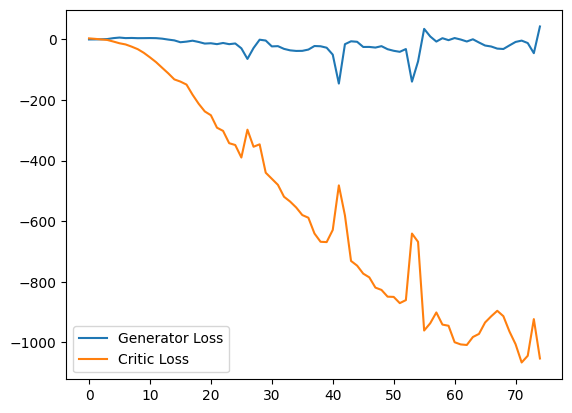

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: -1.1848022084236145, critic loss: -989.3525144226077


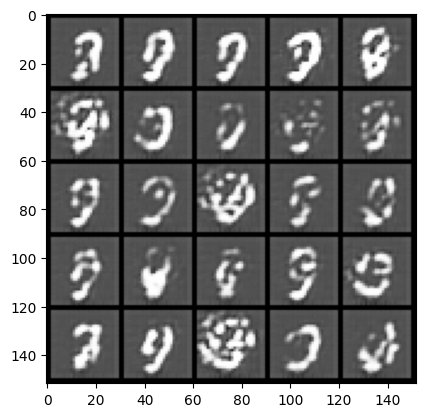

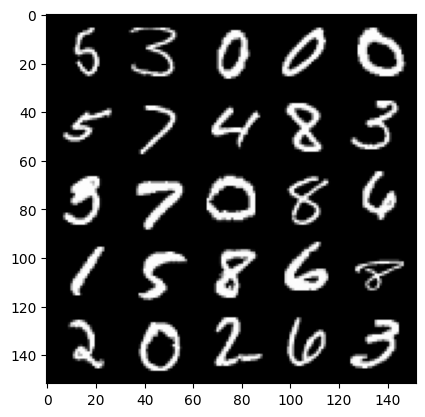

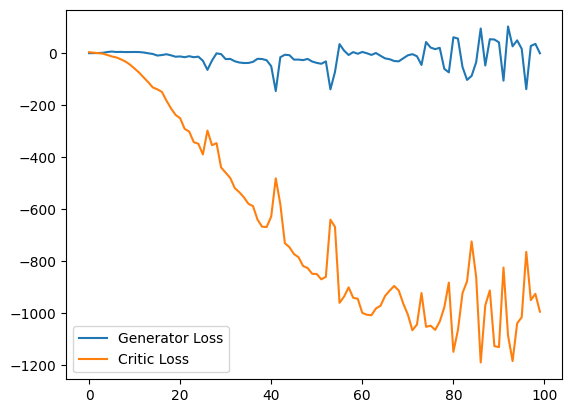

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: -3.9022346167564392, critic loss: -335.89930414428704


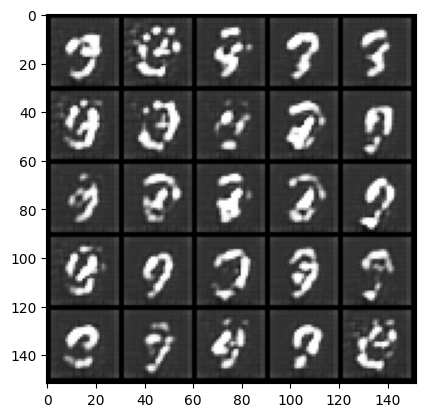

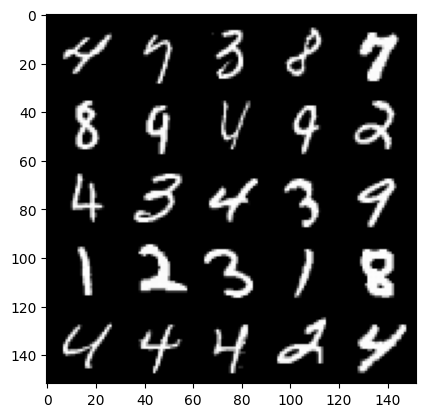

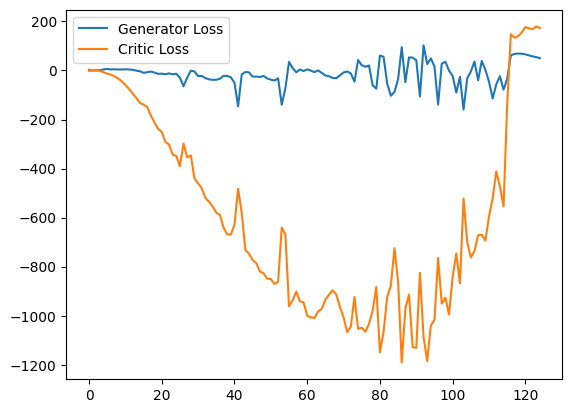

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 49.02458729553223, critic loss: 74.90510015029918


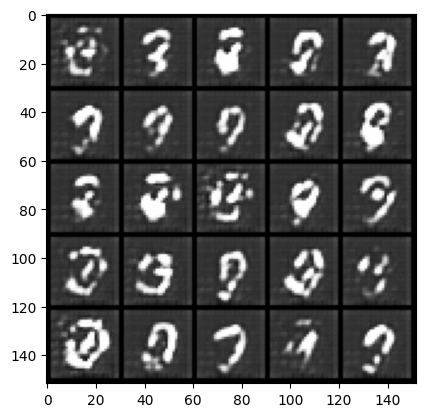

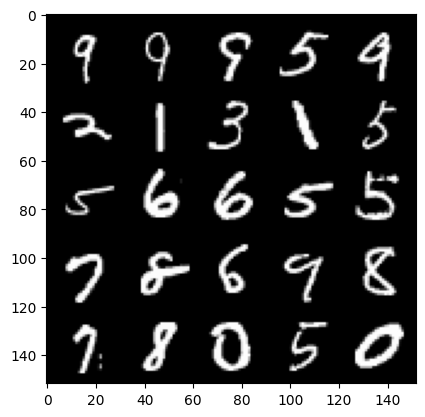

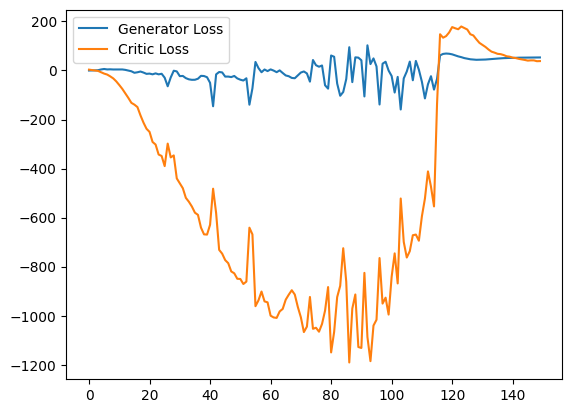

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 48.30564835357666, critic loss: 41.73343484497074


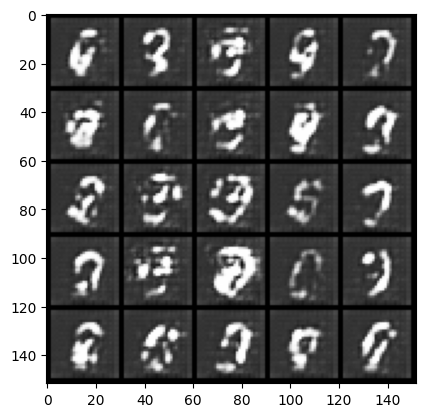

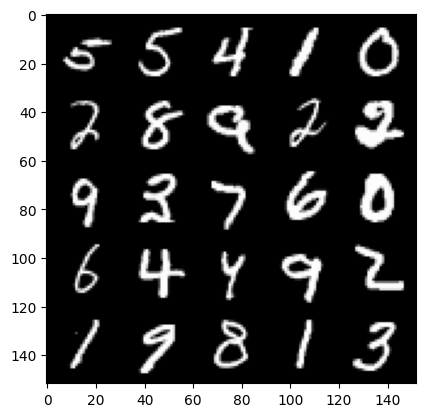

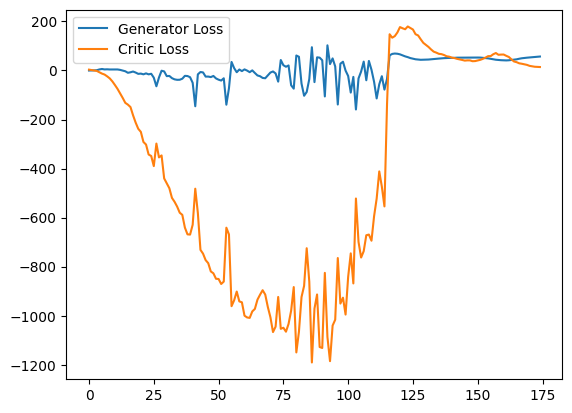

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 67.01138079071045, critic loss: 3.2037328485488903


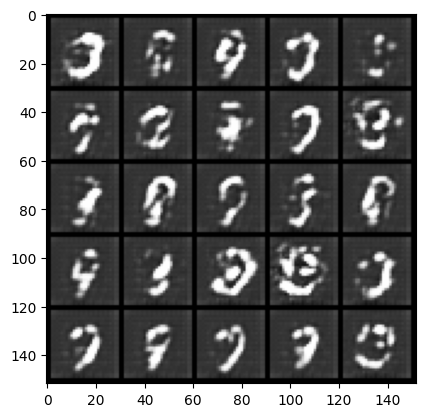

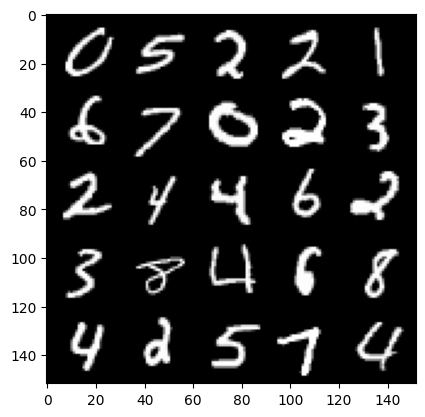

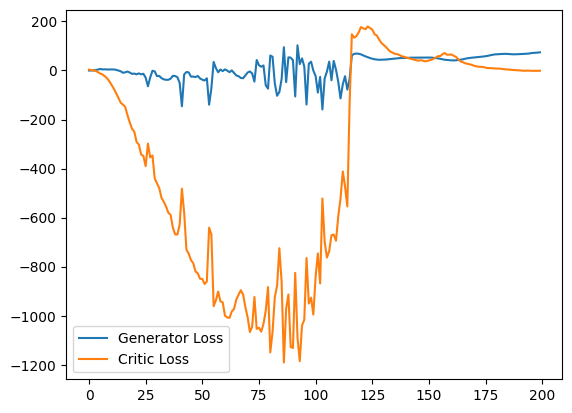

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 63.177089805603025, critic loss: 8.55885253810883


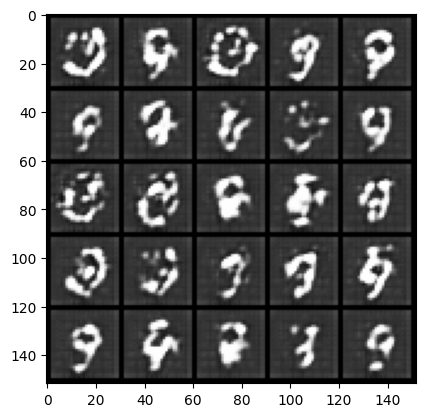

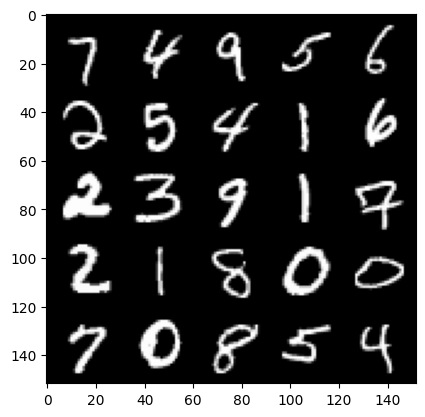

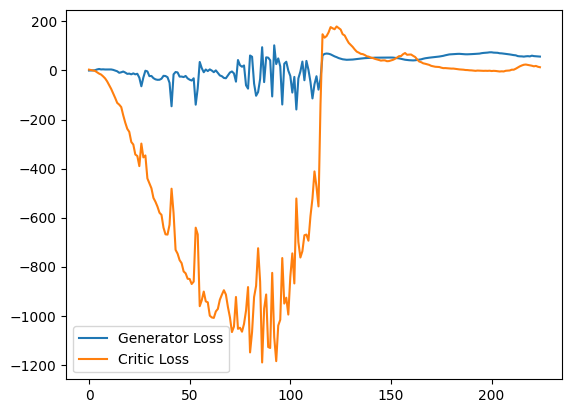

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 46.99181772613525, critic loss: -0.025642703819272555


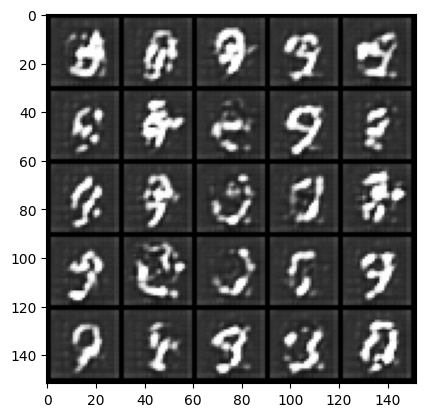

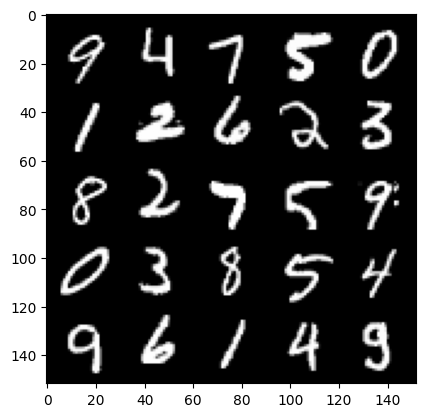

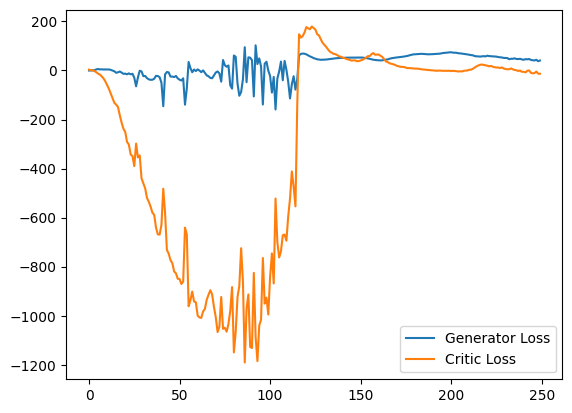

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 37.472812255859374, critic loss: -13.74256794834137


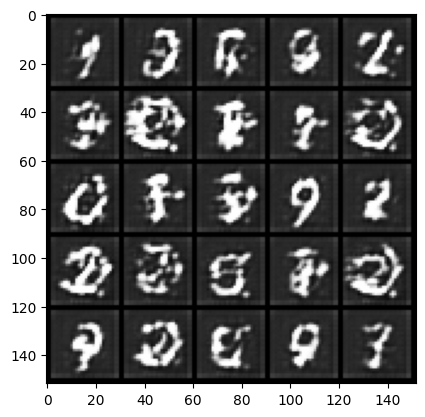

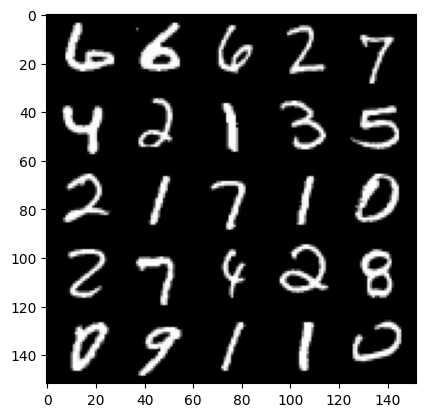

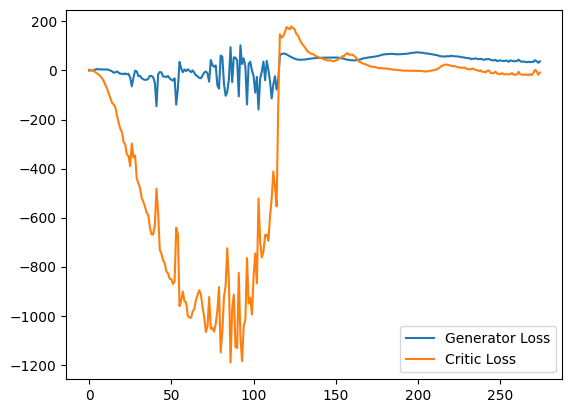

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 28.735959596157073, critic loss: -13.418028430747976


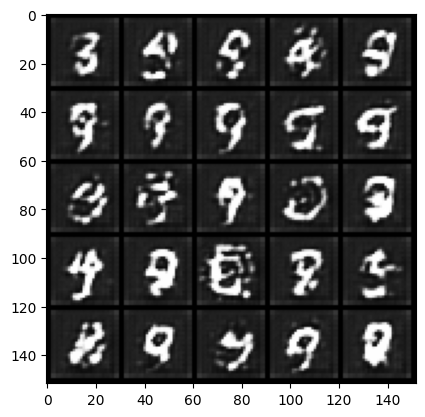

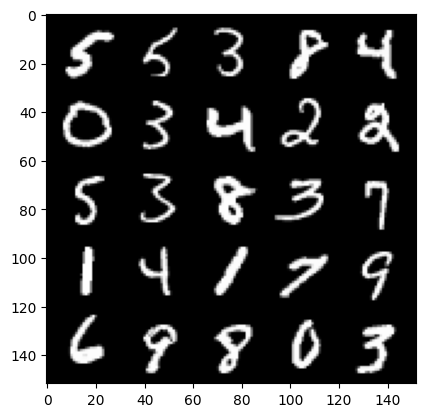

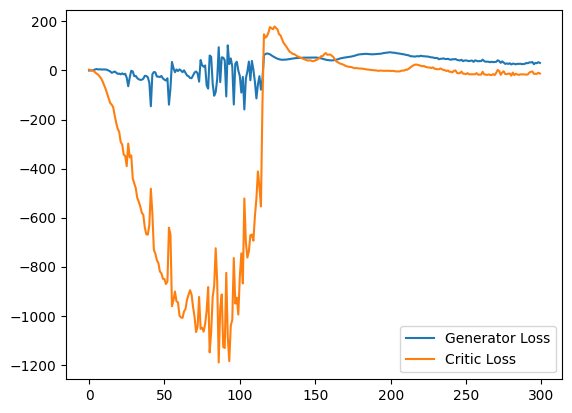

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
